<a href="https://colab.research.google.com/github/dfrepos/biocomp/blob/main/Filtros_Plasmonicos_Regression_biocompFotonica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelagem de Rede Neural Artificial para substituição de simulação de dispositivos fotônicos. Dispositivo em análise: filtros plasmônicos**
Este notebook carrega a base de dados simulados numericamente, que estão hospedados no github. 
Para mais informações sobre como foram gerados os indivíduos aleatórios, acessar [este](https://docs.google.com/document/d/1oPG2PWgAsiPtcvPfIa2L_S_nJEU16c26hBEiFvPiMo4/edit?usp=sharing) documento.


# Regressão

### Importando bibliotecas

In [2]:
import pathlib
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import csv
import os
import re
from datetime import datetime

from sklearn.utils import shuffle

### Autorizar acesso ao GDRIVE

In [ ]:
#Para autorizar acesso ao GDRIVE, onde estão as planilhas em .csv

#from google.colab import drive
#drive.mount('/content/drive')
#path = "/content/drive/MyDrive/IFBA - Pesquisa/BioComp"
#os.chdir(path)

### Baixando os dados
Primeiro baixe a base de dados.

In [3]:
nomes_colunas_f = []
nomes_colunas_lamb = []
for i in range(10):
  nomes_colunas_f.append('f'+str(i+1))
for i in range(65):
  nomes_colunas_lamb.append(str(i*5+380))
nomes_colunas = ['MSE'] + nomes_colunas_f + nomes_colunas_lamb
#df_red = pd.read_csv('red.csv',names=nomes_colunas,  sep = ';')
#df_green = pd.read_csv('green.csv',names=nomes_colunas,  sep = ';')
#df_blue = pd.read_csv('blue.csv',names=nomes_colunas,  sep = ';')
#df_CIE1931 = pd.read_csv('CIE1931.csv',  sep = ';')

df_red = pd.read_csv('https://github.com/dfrepos/biocomp/blob/main/red_02122021.csv?raw=true',names=nomes_colunas,  sep = ';') #dfrprojects
df_green = pd.read_csv('https://github.com/dfrepos/biocomp/blob/main/green_02122021.csv?raw=true',names=nomes_colunas,  sep = ';') #dfrprojects
df_blue = pd.read_csv('https://github.com/dfrepos/biocomp/blob/main/blue_02122021.csv?raw=true',names=nomes_colunas,  sep = ';') #dfrprojects
df_CIE1931 = pd.read_csv('https://github.com/dfrepos/biocomp/blob/main/CIE1931_02122021.csv?raw=true', sep = ';') #dfrprojects

### Plotando os melhores individuos

In [4]:
df_sorted_red = df_red.sort_values('MSE', ignore_index=True)
df_sorted_green = df_green.sort_values('MSE', ignore_index=True)
df_sorted_blue = df_blue.sort_values('MSE', ignore_index=True)

In [5]:
R_best = df_sorted_red.iloc[0].loc[nomes_colunas_lamb]
G_best = df_sorted_green.iloc[0].loc[nomes_colunas_lamb]
B_best = df_sorted_blue.iloc[0].loc[nomes_colunas_lamb]
R_ref = df_CIE1931['R_norm']
G_ref = df_CIE1931['G_norm']
B_ref = df_CIE1931['B_norm']
x = df_CIE1931['Lambda']

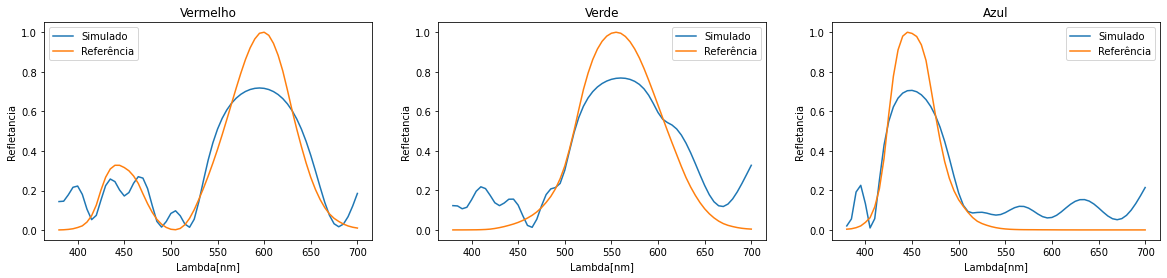

In [6]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(131)
plt.title("Vermelho")
plt.xlabel("Lambda[nm]")
plt.ylabel("Refletancia")
plt.plot(x,R_best,label='Simulado')
plt.plot(x,R_ref,label='Referência')
plt.legend()

ax = fig.add_subplot(132)
plt.title("Verde")
plt.xlabel("Lambda[nm]")
plt.ylabel("Refletancia")
plt.plot(x,G_best,label='Simulado')
plt.plot(x,G_ref,label='Referência')
plt.legend()

ax = fig.add_subplot(133)
plt.title("Azul")
plt.xlabel("Lambda[nm]")
plt.ylabel("Refletancia")
plt.plot(x,B_best,label='Simulado')
plt.plot(x,B_ref,label='Referência')
plt.legend()
plt.show()

### Separando dados de treinamento e teste

A prori, vamos testar com todos os dados simulados, sem utilizar nenhum critério para selecionar os individuos que vão para o treinamento e teste da rede. Mais pra frente podemos fazer um histograma para ver como está a distribuição do MSE (erro médio quadrático entre os espectros obtido e o ideal)

**Multilable regression?** Temos um problema do tipo MIMO. Cada comprimento de onda (que é um label, o output) deve ser previsto a partir das frações de preenchimento (input). Os labels são correlatos entre si. 

In [7]:
dataset = pd.concat([df_red, df_green, df_blue]).reset_index()
dataset.pop('MSE') #A função pop extrai os MSE do dataset
dataset.pop('index') # Removendo tambem a coluna index
dataset = dataset.drop_duplicates()

tamanho_do_dataset_para_treino_e_validacao = round(dataset.shape[0]*.95)
dataset1 = dataset[:tamanho_do_dataset_para_treino_e_validacao]

X = pd.DataFrame([dataset1.pop(x) for x in nomes_colunas_f]).T 
y = dataset1
X, y = shuffle(X, y)
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.1)
X_train = np.array(X_train)
X_validation = np.array(X_validation)
y_train = np.array(y_train)
y_validation = np.array(y_validation)


In [8]:
dataset2 = dataset[tamanho_do_dataset_para_treino_e_validacao:]
X_test = pd.DataFrame([dataset2.pop(x) for x in nomes_colunas_f]).T 
y_test = dataset2
X_test, y_test = shuffle(X_test, y_test)

X_test = np.array(X_test)
y_test = np.array(y_test)


### Analise da qualidade dos dados

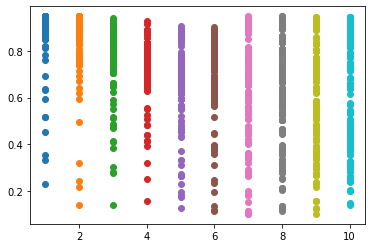

In [9]:
sample_size = 200
i=0
for f in nomes_colunas_f:
  i=i+1
  x = dataset[f].sample(n=sample_size)
  plt.scatter(np.ones(x.size)*i,x)

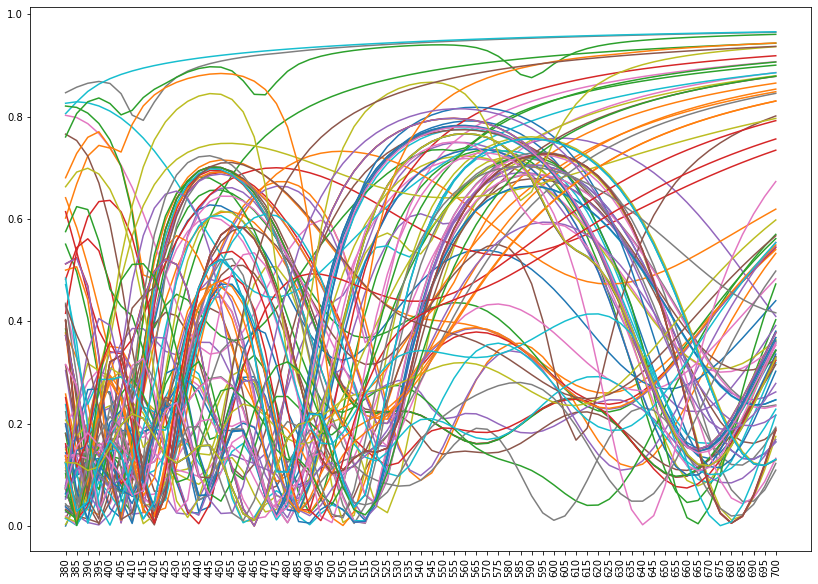

In [10]:
plt.figure(figsize=(14, 10))
for i in range(100):
  y = dataset[nomes_colunas_lamb].iloc[random.randint(0,dataset.shape[0])]
  x = nomes_colunas_lamb
  plt.xticks(rotation=90)
  plt.plot(x,y)


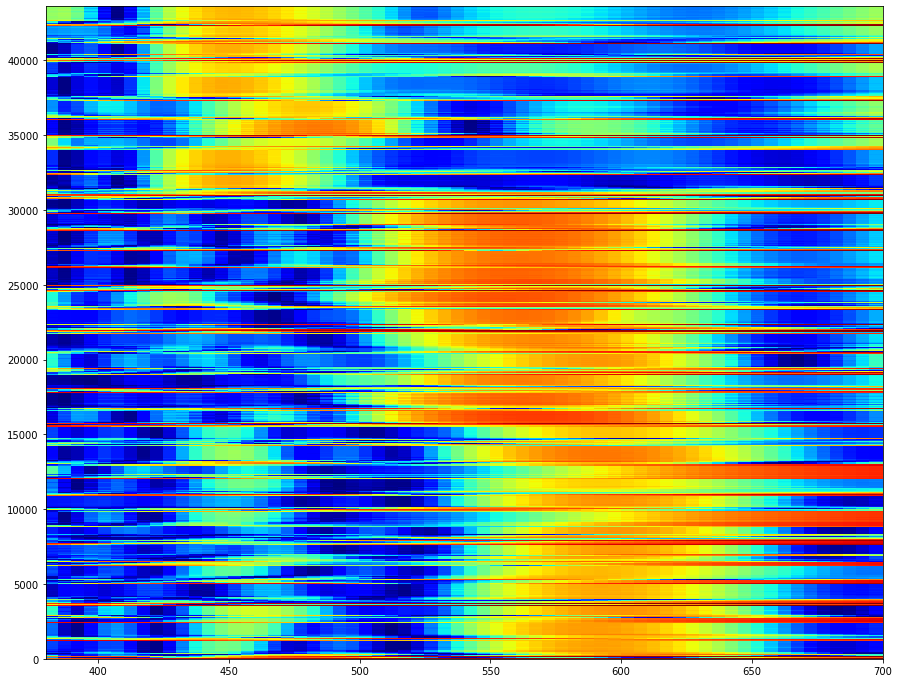

In [11]:
X = np.arange(380, 705, 5)
Y = np.arange(0, dataset.shape[0], 1)
X, Y = np.meshgrid(X, Y)
Z = dataset[nomes_colunas_lamb]
fig = plt.subplots(figsize =(15, 12))
c = plt.pcolor(X, Y, Z, cmap=plt.cm.jet)
plt.show()

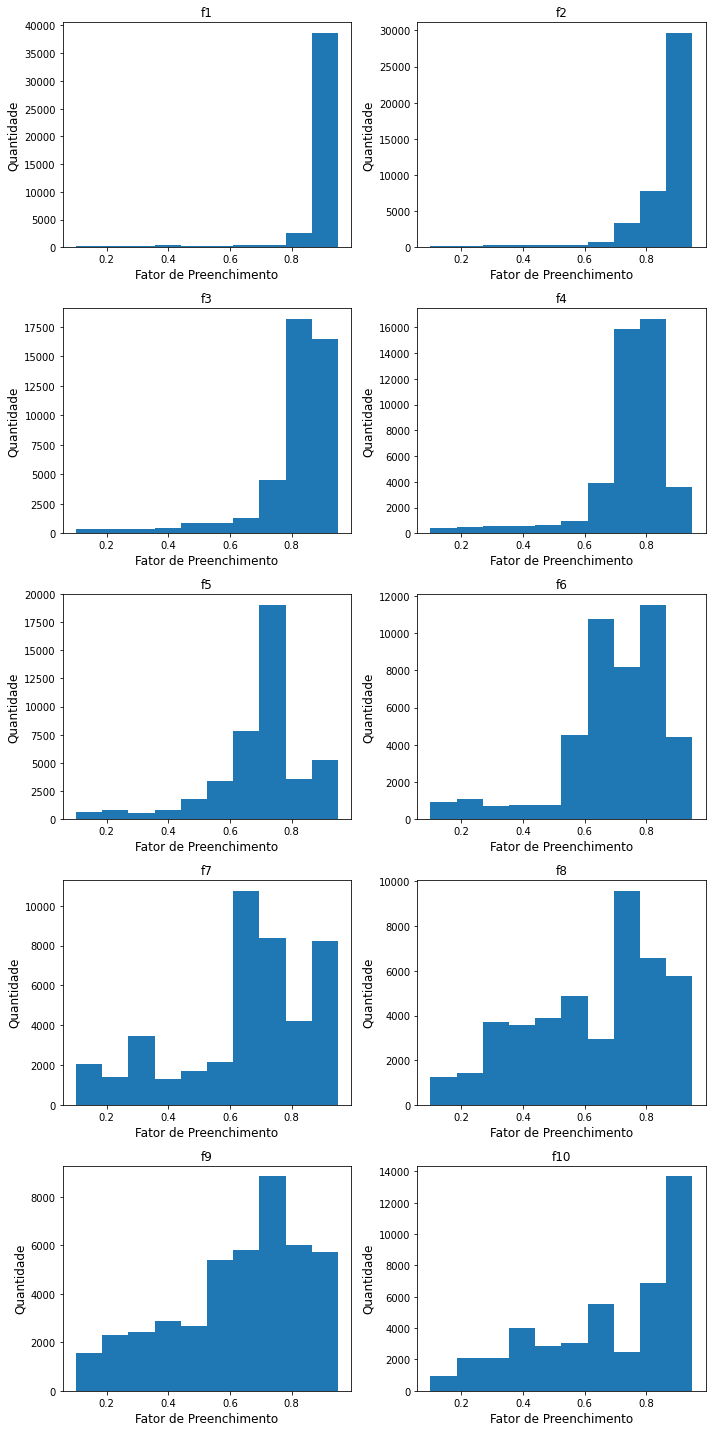

In [12]:
fig = plt.subplots(figsize =(10, 20),tight_layout=True)
i = 0

#fig, axs = plt.subplot([['a)', 'c)'], ['b)', 'c)'], ['d)', 'd)']],constrained_layout=True)
for f in nomes_colunas_f:
  i=i+1
  plt.subplot(5,2,i)
  plt.hist(dataset[f])
  plt.title(f)
  plt.xlabel('Fator de Preenchimento',fontsize=12)
  plt.ylabel('Quantidade',fontsize=12)
plt.show()

## O Modelo

### Libraries

In [ ]:
import time
start_time = time.time()
# print('start_time: ', start_time)

import matplotlib

import math
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import sys
import pickle
import torch
from torch import nn, optim
from torchvision import transforms
from collections import OrderedDict

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


### Arrumando os dados

In [ ]:
input_dim = 10                       ## = no. of input variables columns
output_dim = 65                      ## = no. of output variables columns
no_of_output_nodes = output_dim
X_train = X_train.reshape(-1, input_dim)                        ## 2nd column value is = no. of input variables columns
y_train = y_train.reshape(-1, output_dim)                       ## 2nd column value is = no. of output variables columns
X_validation = X_validation.reshape(-1, input_dim)                      ## 2nd column value is = no. of input variables columns
y_validation = y_validation.reshape(-1, output_dim)     ## 2nd column value is = no. of output variables columns
print('no. of training points: ', len(X_train))
print('no. of validation points: ', len(X_validation))


In [ ]:
###########     manual testing    #########
print('no. of test points: ', len(X_test))
X_test = X_test.reshape(-1, input_dim)                      ## 2nd column value is = no. of input variables columns
y_test = y_test.reshape(-1, output_dim)     ## 2nd column value is = no. of output variables columns
###########################################


### Modelo RNA

In [ ]:
############     model with dropout - 3 layers    #####################
####             dropout_prob leads to variations in mse curve      #########
dropout_prob = 0.0
nodes_hidden_1 = 50
nodes_hidden_2 = 50
nodes_hidden_3 = 50
## nn.Linear() is fully connected layer
model = nn.Sequential(OrderedDict([
                        ('fc1', nn.Linear(input_dim, nodes_hidden_1)),
                        ('relu', nn.ReLU()),
                        ('dropout', nn.Dropout(dropout_prob)),
                        ('fc2', nn.Linear(nodes_hidden_1, nodes_hidden_2)),
                        ('relu', nn.ReLU()),
                        ('dropout', nn.Dropout(dropout_prob)),
                        ('fc3', nn.Linear(nodes_hidden_2, nodes_hidden_3)),
                        ('relu', nn.ReLU()),
                        ('dropout', nn.Dropout(dropout_prob)),
                        ('fc4', nn.Linear(nodes_hidden_3, output_dim)),
                        ]))


In [ ]:
# ############     model with dropout - 2 layers     #####################
# ####             dropout_prob leads to variations in mse curve    ###########
# dropout_prob = 0.1           # 0.5 - used in nvidia model-behavioural cloning
# nodes_hidden_1 = 50
# nodes_hidden_2 = 50
# ## nn.Linear() is fully connected layer
# model = nn.Sequential(OrderedDict([
#                         ('fc1', nn.Linear(input_dim, nodes_hidden_1)),
#                         ('relu', nn.ReLU()),
#                         ('dropout', nn.Dropout(dropout_prob)),
#                         ('fc2', nn.Linear(nodes_hidden_1, nodes_hidden_2)),
#                         ('relu', nn.ReLU()),
#                         ('dropout', nn.Dropout(dropout_prob)),
#                         ('fc3', nn.Linear(nodes_hidden_2, output_dim)),
#                         ]))

In [ ]:
print(model)
# model.double()
# print(X_train)
print(X_train.shape, y_train.shape)



criterion = nn.MSELoss()
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(device)
## move model to gpu if available, else cpu
# model.to(device)

### Realizando o treinamento

In [ ]:
epochs = 5000
# Convert numpy array to torch Variable
# inputs = torch.from_numpy(X_train).requires_grad_()
# labels = torch.from_numpy(y_train)
inputs = torch.Tensor((X_train))
labels = torch.Tensor((y_train))
inputs_validation = torch.Tensor((X_validation))
labels_validation = torch.Tensor((y_validation))
running_loss = []
running_loss_validation = []
for epoch in range(epochs):
    epoch += 1
        
    #################   train the model   ######################
    model.train()    # prep model for training
    # Clear gradients w.r.t. parameters, else gradients will be added up with every previous pass
    optimizer.zero_grad() 
    # Forward to get output
    outputs = model(inputs)
    # Calculate Loss
    loss = criterion(outputs, labels)       ## mean squared error
    # Getting gradients w.r.t. parameters
    loss.backward()
    # Updating parameters
    optimizer.step()         ## take a step with optimizer to update the weights
    running_loss.append(loss.item())

       
    # ###############    validate the model (not showing fluctuations)      ###################
    # # Turn off gradients for validation, saves memory and computations
    # with torch.no_grad():
    #     ## this turns off dropout for evaluation mode of model
    #     model.eval()      # prep model for evaluation
    #     outputs_validation = model(inputs_validation)
    #     loss_validation = criterion(outputs_validation, labels_validation)
    #     running_loss_validation.append(loss_validation.item())
    


    # ###############    validate the model (showing fluctuations)      ###################
    outputs_validation = model(inputs_validation)
    loss_validation = criterion(outputs_validation, labels_validation)
    running_loss_validation.append(loss_validation.item())
        
    

    print('epoch: {}, mse_loss: {:.6f}, mse_loss_validation: {:.6f}'.format(epoch, loss.item(), loss_validation.item()))
    # print(mean_squared_error(outputs_validation,labels_validation))



    # if (epoch == 1000):
    #     torch.save(model.state_dict(), 'checkpoint_1000.pth')
    # elif (epoch == 2500):
    #     torch.save(model.state_dict(), 'checkpoint_2500.pth')
    # elif (epoch == 5000):
    #     torch.save(model.state_dict(), 'checkpoint_5000.pth')        
    # elif (epoch == 7500):
    #     torch.save(model.state_dict(), 'checkpoint_7500.pth')        
    # elif (epoch == 10000):
    #     torch.save(model.state_dict(), 'checkpoint_10000.pth')        
    # elif (epoch == 12500):
    #     torch.save(model.state_dict(), 'checkpoint_12500.pth')        
    # elif (epoch == 15000):
    #     torch.save(model.state_dict(), 'checkpoint_15000.pth')    

In [ ]:
# save the model, as weights & parameters are stored in model.state_dict()
# print(model.state_dict().keys())
# print(model.state_dict())
#### torch.save(model.state_dict(), 'checkpoint-epochs-{}.pth'.format(epochs))
torch.save(model.state_dict(), 'checkpoint1.pth')


In [ ]:
# # load the saved model at particular epochs to compare
#state_dict = torch.load('checkpoint.pth')
# load the saved model
#### state_dict = torch.load('checkpoint-epochs-{}.pth'.format(epochs))
# state_dict = torch.load('checkpoint.pth')
# state_dict = torch.load('checkpoint-simple_waveguide_neff_pytorch_1_epochs-5000.pth')
#model.load_state_dict(state_dict)


### Purely inference

In [ ]:

#predicted_on_X_train = model(torch.Tensor(X_train).requires_grad_()).data.numpy()
#predicted_on_X_validation = model(torch.Tensor(X_validation).requires_grad_()).data.numpy()
#predicted_on_X_test = model(torch.Tensor(X_test).requires_grad_()).data.numpy()
with torch.no_grad():
    ## this turns off dropout for evaluation mode of model
    model.eval()
    predicted_on_X_train = model(torch.Tensor(X_train)).data.numpy()
    predicted_on_X_validation = model(torch.Tensor(X_validation)).data.numpy()
    predicted_on_X_test = model(torch.Tensor(X_test)).data.numpy()
    #print(predicted_on_X_test)

end_time = time.time()
print('end_time: ', end_time)
print('time taken to train in sec: ', (end_time - start_time))

### Diminuindo o tamanho do vetor de erro mse??? Executar apenas uma vez, se não dá erro!

In [ ]:
mse_training_interval = 10
mse_validation_interval = 10
running_loss = running_loss[::mse_training_interval]
running_loss_index = [i for i in range(1, epochs, mse_training_interval)]
running_loss_validation = running_loss_validation[::mse_validation_interval]
running_loss_validation_index = [i for i in range(1, epochs, mse_validation_interval)]
print('mse lengths: ', len(running_loss), len(running_loss_validation))
# print('running_loss_index: ', running_loss_index)
# print('running_loss_validation_index: ', running_loss_validation_index)




## Plotando resultados

### Resultados do treinamento

In [ ]:
###############################################################
#################   plotting graphs together - neff  ################
###############################################################

plt.figure(figsize = [30, 20])
plt.suptitle('pcf - neff - (epochs-{}) - pyTorch'.format(epochs), fontsize=25, 
                color='r', fontweight='bold')     ## giving title on top of all subplots


plt.subplot(231)
plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
plt.legend(loc='best', fontsize=10)
plt.xlabel('epochs#', fontsize=15)


# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(y_train[:,0], 'ro', markersize=12, label='y_train')
# Plot predictions
plt.plot(predicted_on_X_train[:,0], 'b*', markersize=12, label='predicted_on_X_train')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(233)
# Plot true data
plt.plot(y_validation[:,0], 'ro', markersize=12, label='y_validation')
# Plot predictions
plt.plot(predicted_on_X_validation[:,0], 'b*', markersize=12, label='predicted_on_X_validation')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(234)
# Plot true data
plt.plot(y_test[:,0], 'ro', markersize=12, label='y_test')
# Plot predictions
plt.plot(predicted_on_X_test[:,0], 'b*', markersize=12, label='predicted_on_X_test')
# Legend and plot
plt.legend(loc='best', fontsize=10)


#plt.figure()
plt.subplot(235)
xx = y_train[:,0]
yy = predicted_on_X_train[:,0]
xx_validation = y_validation[:,0]
yy_validation = predicted_on_X_validation[:,0]
xx_test = y_test[:,0]
yy_test = predicted_on_X_test[:,0]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='train', marker='o', facecolors='', edgecolors='red', s=50)
plt.scatter(xx_validation, yy_validation, label='validation', marker='o', facecolors='', edgecolors='blue', s=50)
plt.scatter(xx_test, yy_test, label='test', marker='o', facecolors='', edgecolors='black', s=50)
plt.legend(loc='best', fontsize=10)
plt.xlabel('true-values', fontsize=15)
plt.ylabel('predicted', fontsize=15)


# plt.figure()
plt.subplot(236)
true_values = y_test[:,0]
predicted_values = predicted_on_X_test[:,0]
x_index = [i for i in range(len(true_values))]
error_values = predicted_values - true_values
plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
                    ecolor='black', elinewidth=2, capsize=10);
plt.grid(linestyle='--', linewidth=1)



print()
print("o/p of test set:           \n", y_test[:,0])
print("predicted o/p of test set: \n", predicted_on_X_test[:,0])
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))



In [ ]:
###############################################################
#################   plotting graphs together - Aeff  ################
###############################################################

plt.figure(figsize = [30, 20])

plt.suptitle('pcf - Aeff - (epochs-{}) - pyTorch'.format(epochs), fontsize=25, 
                color='r', fontweight='bold')     ## giving title on top of all subplots

plt.subplot(231)
plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
plt.legend(loc='best', fontsize=10)
plt.xlabel('epochs#', fontsize=15)


# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(y_train[:,1], 'ro', markersize=12, label='y_train')
# Plot predictions
plt.plot(predicted_on_X_train[:,1], 'b*', markersize=12, label='predicted_on_X_train')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(233)
# Plot true data
plt.plot(y_validation[:,1], 'ro', markersize=12, label='y_validation')
# Plot predictions
plt.plot(predicted_on_X_validation[:,1], 'b*', markersize=12, label='predicted_on_X_validation')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(234)
# Plot true data
plt.plot(y_test[:,1], 'ro', markersize=12, label='y_test')
# Plot predictions
plt.plot(predicted_on_X_test[:,1], 'b*', markersize=12, label='predicted_on_X_test')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(235)
xx = y_train[:,1]
yy = predicted_on_X_train[:,1]
xx_validation = y_validation[:,1]
yy_validation = predicted_on_X_validation[:,1]
xx_test = y_test[:,1]
yy_test = predicted_on_X_test[:,1]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='train', marker='o', facecolors='', edgecolors='red', s=50)
plt.scatter(xx_validation, yy_validation, label='validation', marker='o', facecolors='', edgecolors='blue', s=50)
plt.scatter(xx_test, yy_test, label='test', marker='o', facecolors='', edgecolors='black', s=50)
plt.legend(loc='best', fontsize=10)
plt.xlabel('true-values', fontsize=15)
plt.ylabel('predicted', fontsize=15)


# plt.figure()
plt.subplot(236)
true_values = y_test[:,1]
predicted_values = predicted_on_X_test[:,1]
x_index = [i for i in range(len(true_values))]
error_values = predicted_values - true_values
plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
                    ecolor='black', elinewidth=2, capsize=10);
plt.grid(linestyle='--', linewidth=1)



print()
print("o/p of test set:           \n", (y_test[:,1]))
print("predicted o/p of test set: \n", (predicted_on_X_test[:,1]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))




In [ ]:
# ####################################################################################################
# ###########    saving predicted data to excel file   ##############
# plt.show()
# n1 = xx
# n2 = yy
# n3 = true_values
# n4 = predicted_values
# n5 = error_values
# ## convert your array into a dataframe
# # df = pd.DataFrame(l1, columns=['a'])
# df1 = pd.DataFrame(OrderedDict({'y_train':n1, 'predicted_on_X_train':n2}))
# df2 = pd.DataFrame({'y_test':n3, 'predicted_on_X_test':n4, 'error_values':n5}, 
#                         columns=['y_test', 'predicted_on_X_test', 'error_values'])
# ## save to xlsx file
# # filepath_1 = 'test_excel_file_1.xlsx'
# df1.to_excel('test_excel_file_1.xlsx', sheet_name='sheet1', index=False)
# df2.to_excel('test_excel_file_2.xlsx', sheet_name='sheet1', index=False)
# # sys.exit()
# ####################################################################################################

###############################################################
#################   plotting graphs together - disp  ################
###############################################################

plt.figure(figsize = [30, 20])
plt.suptitle('pcf - disp - (epochs-{}) - pyTorch'.format(epochs), fontsize=25, 
                color='r', fontweight='bold')     ## giving title on top of all subplots


plt.subplot(231)
plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
plt.legend(loc='best', fontsize=10)
plt.xlabel('epochs#', fontsize=15)


# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(y_train[:,2], 'ro', markersize=12, label='y_train')
# Plot predictions
plt.plot(predicted_on_X_train[:,2], 'b*', markersize=12, label='predicted_on_X_train')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(233)
# Plot true data
plt.plot(y_validation[:,2], 'ro', markersize=12, label='y_validation')
# Plot predictions
plt.plot(predicted_on_X_validation[:,2], 'b*', markersize=12, label='predicted_on_X_validation')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(234)
# Plot true data
plt.plot(y_test[:,2], 'ro', markersize=12, label='y_test')
# Plot predictions
plt.plot(predicted_on_X_test[:,2], 'b*', markersize=12, label='predicted_on_X_test')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(235)
xx = y_train[:,2]
yy = predicted_on_X_train[:,2]
xx_validation = y_validation[:,2]
yy_validation = predicted_on_X_validation[:,2]
xx_test = y_test[:,2]
yy_test = predicted_on_X_test[:,2]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='train', marker='o', facecolors='', edgecolors='red', s=50)
plt.scatter(xx_validation, yy_validation, label='validation', marker='o', facecolors='', edgecolors='blue', s=50)
plt.scatter(xx_test, yy_test, label='test', marker='o', facecolors='', edgecolors='black', s=50)
plt.legend(loc='best', fontsize=10)
plt.xlabel('true-values', fontsize=15)
plt.ylabel('predicted', fontsize=15)


# plt.figure()
plt.subplot(236)
true_values = y_test[:,2]
predicted_values = predicted_on_X_test[:,2]
x_index = [i for i in range(len(true_values))]
error_values = predicted_values - true_values
plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
                    ecolor='black', elinewidth=2, capsize=10);
plt.grid(linestyle='--', linewidth=1)



print()
print("o/p of test set:           \n", y_test[:,2])
print("predicted o/p of test set: \n", predicted_on_X_test[:,2])
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))




In [ ]:
###############################################################
#################   plotting graphs together - conf-loss  ################
###############################################################

plt.figure(figsize = [30, 20])
plt.suptitle('pcf - conf_loss - (epochs-{}) - pyTorch'.format(epochs), fontsize=25, 
                color='r', fontweight='bold')     ## giving title on top of all subplots


plt.subplot(231)
plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
plt.legend(loc='best', fontsize=10)
plt.xlabel('epochs#', fontsize=15)


# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(y_train[:,3], 'ro', markersize=12, label='y_train')
# Plot predictions
plt.plot(predicted_on_X_train[:,3], 'b*', markersize=12, label='predicted_on_X_train')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(233)
# Plot true data
plt.plot(y_validation[:,3], 'ro', markersize=12, label='y_validation')
# Plot predictions
plt.plot(predicted_on_X_validation[:,3], 'b*', markersize=12, label='predicted_on_X_validation')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(234)
# Plot true data
plt.plot(y_test[:,3], 'ro', markersize=12, label='y_test')
# Plot predictions
plt.plot(predicted_on_X_test[:,3], 'b*', markersize=12, label='predicted_on_X_test')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(235)
xx = y_train[:,3]
yy = predicted_on_X_train[:,3]
xx_validation = y_validation[:,3]
yy_validation = predicted_on_X_validation[:,3]
xx_test = y_test[:,3]
yy_test = predicted_on_X_test[:,3]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='train', marker='o', facecolors='', edgecolors='red', s=50)
plt.scatter(xx_validation, yy_validation, label='validation', marker='o', facecolors='', edgecolors='blue', s=50)
plt.scatter(xx_test, yy_test, label='test', marker='o', facecolors='', edgecolors='black', s=50)
plt.legend(loc='best', fontsize=10)
plt.xlabel('true-values', fontsize=15)
plt.ylabel('predicted', fontsize=15)


# plt.figure()
plt.subplot(236)
true_values = y_test[:,3]
predicted_values = predicted_on_X_test[:,3]
x_index = [i for i in range(len(true_values))]
error_values = predicted_values - true_values
plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
                    ecolor='black', elinewidth=2, capsize=10);
plt.grid(linestyle='--', linewidth=1)



print()
print("o/p of test set:           \n", y_test[:,3])
print("predicted o/p of test set: \n", predicted_on_X_test[:,3])
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))

In [ ]:
###############################################################
#################   plotting graphs together - conf-loss-in-log10  ################
###############################################################

plt.figure(figsize = [30, 20])
plt.suptitle('pcf - conf_loss_in_log10 - (epochs-{}) - pyTorch'.format(epochs), fontsize=25, 
                color='r', fontweight='bold')     ## giving title on top of all subplots


plt.subplot(231)
plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
plt.legend(loc='best', fontsize=10)
plt.xlabel('epochs#', fontsize=15)


# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(y_train[:,4], 'ro', markersize=12, label='y_train')
# Plot predictions
plt.plot(predicted_on_X_train[:,4], 'b*', markersize=12, label='predicted_on_X_train')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(233)
# Plot true data
plt.plot(y_validation[:,4], 'ro', markersize=12, label='y_validation')
# Plot predictions
plt.plot(predicted_on_X_validation[:,4], 'b*', markersize=12, label='predicted_on_X_validation')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(234)
# Plot true data
plt.plot(y_test[:,4], 'ro', markersize=12, label='y_test')
# Plot predictions
plt.plot(predicted_on_X_test[:,4], 'b*', markersize=12, label='predicted_on_X_test')
# Legend and plot
plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(235)
xx = y_train[:,4]
yy = predicted_on_X_train[:,4]
xx_validation = y_validation[:,4]
yy_validation = predicted_on_X_validation[:,4]
xx_test = y_test[:,4]
yy_test = predicted_on_X_test[:,4]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='train', marker='o', facecolors='', edgecolors='red', s=50)
plt.scatter(xx_validation, yy_validation, label='validation', marker='o', facecolors='', edgecolors='blue', s=50)
plt.scatter(xx_test, yy_test, label='test', marker='o', facecolors='', edgecolors='black', s=50)
plt.legend(loc='best', fontsize=10)
plt.xlabel('true-values', fontsize=15)
plt.ylabel('predicted', fontsize=15)


# plt.figure()
plt.subplot(236)
true_values = y_test[:,4]
predicted_values = predicted_on_X_test[:,4]
x_index = [i for i in range(len(true_values))]
error_values = predicted_values - true_values
plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
                    ecolor='black', elinewidth=2, capsize=10);
plt.grid(linestyle='--', linewidth=1)



print()
print("o/p of test set:           \n", (y_test[:,4]))
print("predicted o/p of test set: \n", (predicted_on_X_test[:,4]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))
print()

In [ ]:
###############################################################
#################   plotting graphs together - conf-loss-without/with-log10  ################
###############################################################

plt.figure(figsize = [13, 5])

plt.subplot(121)
true_values = y_test[:,3]
predicted_values = predicted_on_X_test[:,3]
print(true_values)
print(predicted_values)
x_index = [i for i in range(len(true_values))]
error_values = predicted_values - true_values
plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
                    ecolor='black', elinewidth=2, capsize=10)
plt.yscale('log')
plt.grid(linestyle='--', linewidth=1)
plt.title('conf-loss-without-log10', fontsize=25)


plt.subplot(122)
true_values = 10**(y_test[:,4])
predicted_values = 10**(predicted_on_X_test[:,4])
print(true_values)
print(predicted_values)
x_index = [i for i in range(len(true_values))]
error_values = predicted_values - true_values
plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
                    ecolor='black', elinewidth=2, capsize=10)
plt.yscale('log')                    
plt.grid(linestyle='--', linewidth=1)
plt.title('conf-loss-with-log10', fontsize=25)




# ####################################################################################################
# ###########    saving predicted data to excel file   ##############
# plt.show()
# n1 = xx
# n2 = yy
# n3 = true_values
# n4 = predicted_values
# n5 = error_values
# ## convert your array into a dataframe
# # df = pd.DataFrame(l1, columns=['a'])
# df1 = pd.DataFrame(OrderedDict({'y_train':n1, 'predicted_on_X_train':n2}))
# df2 = pd.DataFrame({'y_test':n3, 'predicted_on_X_test':n4, 'error_values':n5}, 
#                         columns=['y_test', 'predicted_on_X_test', 'error_values'])
# ## save to xlsx file
# # filepath_1 = 'test_excel_file_1.xlsx'
# df1.to_excel('test_excel_file_1.xlsx', sheet_name='sheet1', index=False)
# df2.to_excel('test_excel_file_2.xlsx', sheet_name='sheet1', index=False)
# # sys.exit()
# ####################################################################################################



plt.show()

### Plotando curvas real vs previsto

In [ ]:
X_test[:1000][0]

In [ ]:
fig = plt.figure(figsize=(5, 4))

plt.title(" ")
plt.xlabel("Lambda[nm]")
plt.ylabel("Refletancia")
plt.plot(x,predicted_on_X_train[:44500][0],label='Simulado')
#plt.plot(x,R_ref,label='Referência')
plt.legend()

plt.show()

In [ ]:
df = pd.DataFrame(predicted_on_X_train)

In [ ]:
df.drop_duplicates()